# Домашнее задание № 9

### Задание 1 (10 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb

На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base). Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

Для обоих моделей качество должно быть >0.10 по f-мере (прогоните несколько экспериментов если у вас получаются нули, изменяя параметры).
Также для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой.
Для RuModernBERT дополнительно сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert.




Импортируем необходимые библиотеки:

In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [2]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

from tqdm.auto import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

Необходимые функции:

In [4]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [5]:
def train(model, iterator, optimizer, criterion, print_every=1000):

    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):

        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))



        loss.backward()
        optimizer.step()
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')

    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()


            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)# / len(iterator)

In [6]:
def predict(model, iterator):

    preds = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            ys = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            preds.extend(ys)

    return preds

In [7]:
class CLF(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, texts):

        mask = (texts != tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)

        return outputs

Загрузим датасет:

In [9]:
  data = pd.read_csv('lenta_sample.csv')

In [10]:
data

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27
3,https://lenta.ru/news/2009/07/23/refuse/,Лужков отказался трудоустраивать китайцев с Че...,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия,Все,2009/07/23
4,https://lenta.ru/news/2012/09/29/factory/,По факту пожара на заводе в Югре заведено дело,Следственный комитет России возбудил уголовное...,Россия,Все,2012/09/29
...,...,...,...,...,...,...
602,https://lenta.ru/news/2014/09/14/pattern/,1914. Выкройки для раненых,"В дополнение к выкройкам белья для раненых, ра...",Библиотека,Первая мировая,2014/09/14
603,https://lenta.ru/news/2014/12/23/christmas/,1914. Немецкие и британские солдаты отметили п...,24 декабря в Бельгии в районе Ипра произошло н...,Библиотека,Первая мировая,2014/12/23
604,https://lenta.ru/news/2014/10/21/dobrovolec/,1914. Польский доброволец-герой,В числе поступивших в нашу армию добровольцев ...,Библиотека,Первая мировая,2014/10/21
605,https://lenta.ru/news/2014/09/18/postoffice/,1914. Письма в действующую армию на деревню де...,За последнее время на имя начальника штаба Вер...,Библиотека,Первая мировая,2014/09/18


In [12]:
data.dropna(subset=['text', 'topic'], inplace=True)
data

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27
3,https://lenta.ru/news/2009/07/23/refuse/,Лужков отказался трудоустраивать китайцев с Че...,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия,Все,2009/07/23
4,https://lenta.ru/news/2012/09/29/factory/,По факту пожара на заводе в Югре заведено дело,Следственный комитет России возбудил уголовное...,Россия,Все,2012/09/29
...,...,...,...,...,...,...
602,https://lenta.ru/news/2014/09/14/pattern/,1914. Выкройки для раненых,"В дополнение к выкройкам белья для раненых, ра...",Библиотека,Первая мировая,2014/09/14
603,https://lenta.ru/news/2014/12/23/christmas/,1914. Немецкие и британские солдаты отметили п...,24 декабря в Бельгии в районе Ипра произошло н...,Библиотека,Первая мировая,2014/12/23
604,https://lenta.ru/news/2014/10/21/dobrovolec/,1914. Польский доброволец-герой,В числе поступивших в нашу армию добровольцев ...,Библиотека,Первая мировая,2014/10/21
605,https://lenta.ru/news/2014/09/18/postoffice/,1914. Письма в действующую армию на деревню де...,За последнее время на имя начальника штаба Вер...,Библиотека,Первая мировая,2014/09/18


In [13]:
data.shape

(607, 6)

In [14]:
# в берте максимальная длина обычно ограничена 512
MAX_LEN = 512

In [15]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data['topic']))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data['topic']]

In [16]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

## **ModernBERT-base**

Попробуем ModernBERT-base с заморозкой (с обучением только последнего слоя):

In [ ]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [ ]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.06666666666666667
1
Eval -  0.09583333333333333
2
Eval -  0.09583333333333333
3
Eval -  0.1
4
Eval -  0.12916666666666665
5
Eval -  0.125
6
Eval -  0.12916666666666665
7
Eval -  0.13333333333333333
8
Eval -  0.12916666666666665
9
Eval -  0.12916666666666665
10
Eval -  0.09791666666666667
11
Eval -  0.12708333333333333
12
Eval -  0.1625
13
Eval -  0.1625
14
Eval -  0.16458333333333333
15
Eval -  0.15833333333333333
16
Eval -  0.16458333333333333
17
Eval -  0.12916666666666665
18
Eval -  0.1625
19
Eval -  0.16458333333333333
20
Eval -  0.16458333333333333
21
Eval -  0.1625
22
Eval -  0.15833333333333333
23
Eval -  0.12916666666666665
24
Eval -  0.1625
25
Eval -  0.16041666666666665
26
Eval -  0.15833333333333333
27
Eval -  0.16041666666666665
28
Eval -  0.19375
29
Eval -  0.19166666666666665
30
Eval -  0.16041666666666665
31
Eval -  0.225
32
Eval -  0.19166666666666665
33
Eval -  0.15833333333333333
34
Eval -  0.19375
35
Eval -  0.22291666666666665
36
Eval -  0.12916666666666

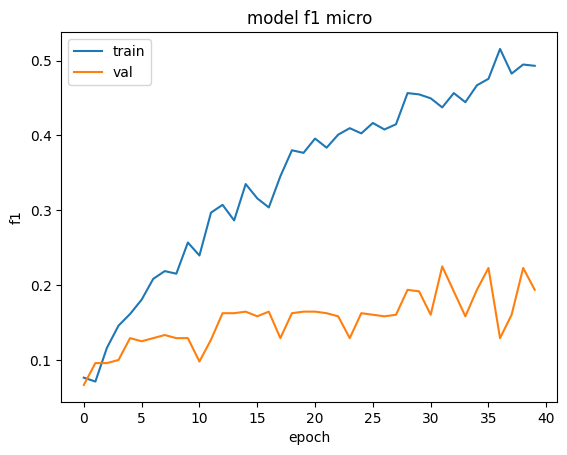

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.60      0.50      0.55         6
          13       1.00      1.00      1.00         1
          14       0.25      1.00      0.40         1
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         5

    accuracy                           0.19        31
   macro avg       0.15   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Теперь ModernBERT-base без заморозки (с обучением всей модели):

In [5]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [ ]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.06666666666666667
1
Eval -  0.0
2
Eval -  0.09583333333333333
3
Eval -  0.06458333333333333
4
Eval -  0.09583333333333333
5
Eval -  0.1625
6
Eval -  0.09375
7
Eval -  0.16041666666666665
8
Eval -  0.12916666666666665
9
Eval -  0.22291666666666665
10
Eval -  0.2895833333333333
11
Eval -  0.29375
12
Eval -  0.19375
13
Eval -  0.2583333333333333
14
Eval -  0.2583333333333333
15
Eval -  0.3208333333333333
16
Eval -  0.22916666666666666
17
Eval -  0.16041666666666665
18
Eval -  0.22083333333333333
19
Eval -  0.1625
20
Eval -  0.25625
21
Eval -  0.22708333333333333
22
Eval -  0.19583333333333333
23
Eval -  0.32291666666666663
24
Eval -  0.2895833333333333
25
Eval -  0.2875
26
Eval -  0.19166666666666665
27
Eval -  0.31875
28
Eval -  0.25625
29
Eval -  0.22083333333333333


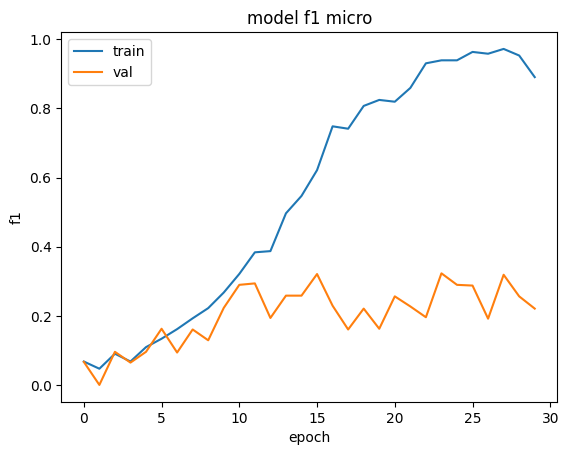

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1
           2       1.00      0.33      0.50         3
           3       0.33      0.50      0.40         2
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           8       0.29      0.67      0.40         3
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.50      0.50      0.50         2
          14       0.00      0.00      0.00         1
          15       0.50      0.25      0.33         4
          16       0.00      0.00      0.00         1

    accuracy                           0.23        31
   macro avg       0.20      0.22      0.18        31
weighted avg       0.25   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

У ModernBERT-base без заморозки качество немного получше, чем у модели с заморозкой

# **RuModernBERT-base**

Попробуем RuModernBERT-base с заморозкой (с обучением только последнего слоя):

In [ ]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [ ]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.15833333333333333
1
Eval -  0.12916666666666665
2
Eval -  0.0625
3
Eval -  0.15833333333333333
4
Eval -  0.09583333333333333
5
Eval -  0.1
6
Eval -  0.09375
7
Eval -  0.13125
8
Eval -  0.12916666666666665
9
Eval -  0.09583333333333333
10
Eval -  0.16041666666666665
11
Eval -  0.19583333333333333
12
Eval -  0.19583333333333333
13
Eval -  0.15833333333333333
14
Eval -  0.18958333333333333
15
Eval -  0.29375
16
Eval -  0.09583333333333333
17
Eval -  0.19583333333333333
18
Eval -  0.16458333333333333
19
Eval -  0.1625
20
Eval -  0.1625
21
Eval -  0.16041666666666665
22
Eval -  0.22708333333333333
23
Eval -  0.19583333333333333
24
Eval -  0.1625
25
Eval -  0.1625
26
Eval -  0.19791666666666666
27
Eval -  0.25625
28
Eval -  0.22291666666666665
29
Eval -  0.26041666666666663
30
Eval -  0.22916666666666666
31
Eval -  0.19375
32
Eval -  0.16041666666666665
33
Eval -  0.1625
34
Eval -  0.22291666666666665
35
Eval -  0.26041666666666663
36
Eval -  0.22708333333333333
37
Eval -  0.1604

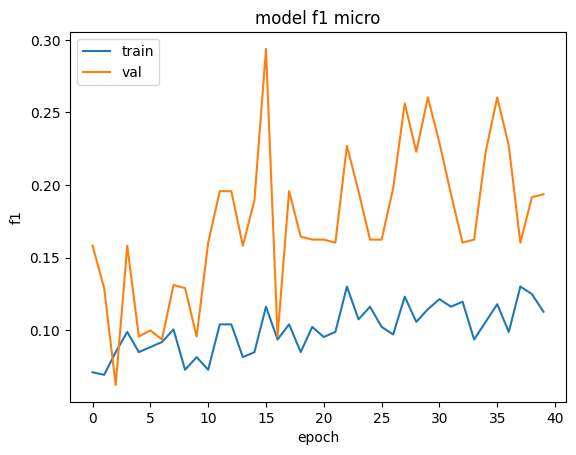

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.20      0.33      0.25         3
           3       0.00      0.00      0.00         2
           4       0.21      0.80      0.33         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           8       0.14      0.33      0.20         3
          10       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1

    accuracy                           0.19        31
   macro avg       0.04      0.11      0.06        31
weighted avg       0.07      0.19      0.10        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Теперь ModernBERT-base без заморозки (с обучением всей модели):

In [17]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [18]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [20]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [21]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.06458333333333333
1
Eval -  0.03125
2
Eval -  0.19375
3
Eval -  0.48333333333333334
4
Eval -  0.5166666666666666
5
Eval -  0.61875
6
Eval -  0.5125
7
Eval -  0.6125
8
Eval -  0.64375
9
Eval -  0.6770833333333333
10
Eval -  0.6729166666666666
11
Eval -  0.675
12
Eval -  0.7104166666666667
13
Eval -  0.7104166666666667
14
Eval -  0.7125
15
Eval -  0.6791666666666667
16
Eval -  0.7104166666666667
17
Eval -  0.65
18
Eval -  0.6416666666666666
19
Eval -  0.6458333333333333
20
Eval -  0.6770833333333333
21
Eval -  0.68125
22
Eval -  0.6770833333333333
23
Eval -  0.675
24
Eval -  0.6770833333333333
25
Eval -  0.68125
26
Eval -  0.6791666666666667
27
Eval -  0.68125
28
Eval -  0.6770833333333333
29
Eval -  0.68125


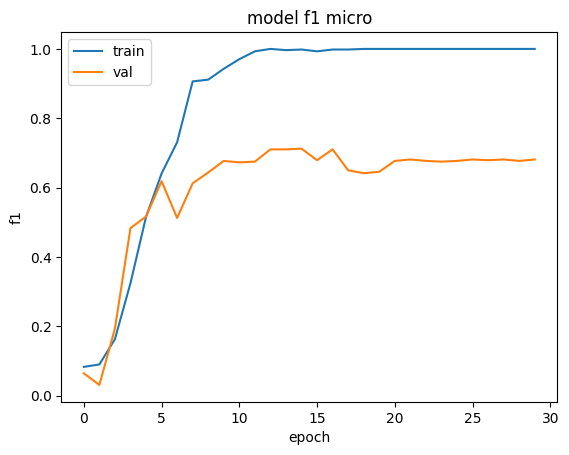

In [22]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [24]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           2       0.75      0.75      0.75         4
           3       1.00      0.67      0.80         3
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         1
           6       0.50      0.67      0.57         3
           7       0.00      0.00      0.00         3
           8       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         1
          12       0.50      1.00      0.67         1
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          16       1.00      1.00      1.00         5

    accuracy                           0.68        31
   macro avg       0.67      0.64      0.63        31
weighted avg       0.75      0.68      0.68        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RuModernBERT, который использует усредненный вектор по всем hidden_state, который выдает bert:

In [25]:
class CLF(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, texts):

        mask = (texts != tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask).last_hidden_state # здесь изменяем [0] на last_hidden_state
        avg_hidden = hidden.mean(dim=1) # здесь усреднение по всем hidden states

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(avg_hidden)) # здесь подаем на вход усреднение
        outputs=self.act(dense_outputs)

        return outputs

In [26]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

In [27]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [29]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [30]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.12708333333333333
1
Eval -  0.1625
2
Eval -  0.29583333333333334
3
Eval -  0.48125
4
Eval -  0.51875
5
Eval -  0.5479166666666666
6
Eval -  0.6083333333333334
7
Eval -  0.6145833333333333
8
Eval -  0.64375
9
Eval -  0.6104166666666666
10
Eval -  0.6479166666666667
11
Eval -  0.6458333333333333
12
Eval -  0.64375
13
Eval -  0.6479166666666667
14
Eval -  0.6458333333333333
15
Eval -  0.6770833333333333
16
Eval -  0.675
17
Eval -  0.64375
18
Eval -  0.6458333333333333
19
Eval -  0.6791666666666667
20
Eval -  0.6791666666666667
21
Eval -  0.68125
22
Eval -  0.6395833333333334
23
Eval -  0.6458333333333333
24
Eval -  0.6479166666666667
25
Eval -  0.6479166666666667
26
Eval -  0.6458333333333333
27
Eval -  0.6729166666666666
28
Eval -  0.6479166666666667
29
Eval -  0.6770833333333333
30
Eval -  0.64375
31
Eval -  0.6458333333333333
32
Eval -  0.6083333333333334
33
Eval -  0.64375
34
Eval -  0.6166666666666667
35
Eval -  0.6520833333333333
36
Eval -  0.6458333333333333
37
Eval -  

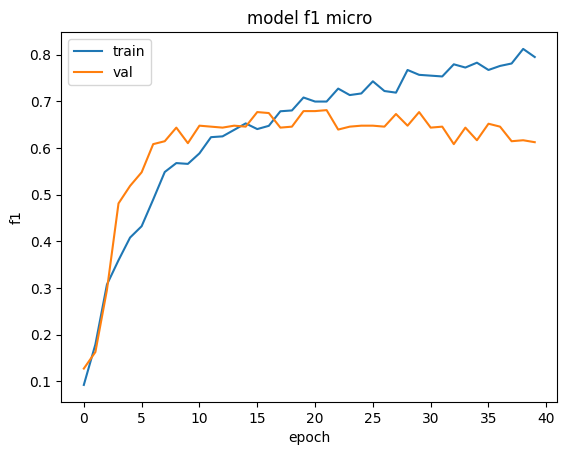

In [31]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [33]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           2       0.50      0.75      0.60         4
           3       1.00      1.00      1.00         3
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         1
           6       0.40      0.67      0.50         3
           7       0.00      0.00      0.00         3
           8       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       0.00      0.00      0.00         1
          12       0.25      1.00      0.40         1
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         1
          16       1.00      0.80      0.89         5

    accuracy                           0.61        31
   macro avg       0.55      0.54      0.51        31
weighted avg       0.64      0.61      0.60        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Модель RuModernBERT-base с заморозкой (дообучением только последнего слоя) показала себя не лучше первых двух моделей (ModernBERT-base с заморозкой и без). Зато последние две модели - RuModernBERT-base без заморозки (с обучением всей модели) и RuModernBERT, использующий усредненный вектор по всем hidden_state, который выдает bert - выдали лучшие результаты. Судя по графику, модель с усредненным вектором самая стабильная из всех, но F1 скор выше у предыдущей модели, обычного RuModernBERT-base без заморозки